In [10]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [11]:
df = pd.read_csv("/content/spam.csv", encoding="latin-1")
df = df.iloc[:, :2]
df.columns = ["label", "message"]

df.head()


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [12]:
df["label"].value_counts()


,count
label,
ham,4825
spam,747


In [14]:
def heuristic_score(text):
    score = 0
    if re.search(r"http[s]?://|www\.", text):
        score += 1
    if re.search(r"[£$€]", text):
        score += 1
    if re.search(r"\b(win|free|offer|urgent|claim|prize|call now)\b", text, re.I):
        score += 1
    return score


In [15]:
df["heuristic_score"] = df["message"].apply(heuristic_score)
df["label_num"] = df["label"].map({"ham": 0, "spam": 1})

df.head()


,label,message,heuristic_score,label_num
0,ham,"Go until jurong point, crazy.. Available only ...",0,0
1,ham,Ok lar... Joking wif u oni...,0,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,1
3,ham,U dun say so early hor... U c already then say...,0,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,0


In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    df["message"],
    df["label_num"],
    test_size=0.2,
    random_state=42,
    stratify=df["label_num"]
)


In [17]:
vectorizer = TfidfVectorizer(
    stop_words="english",
    max_features=3000
)

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


In [18]:
nb_model = MultinomialNB()
nb_model.fit(X_train_vec, y_train)


MultinomialNB()

In [19]:
y_pred = nb_model.predict(X_test_vec)


In [20]:
accuracy_score(y_test, y_pred)


0.9730941704035875

In [21]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.97      1.00      0.98       966
           1       0.98      0.81      0.89       149

    accuracy                           0.97      1115
   macro avg       0.98      0.91      0.94      1115
weighted avg       0.97      0.97      0.97      1115



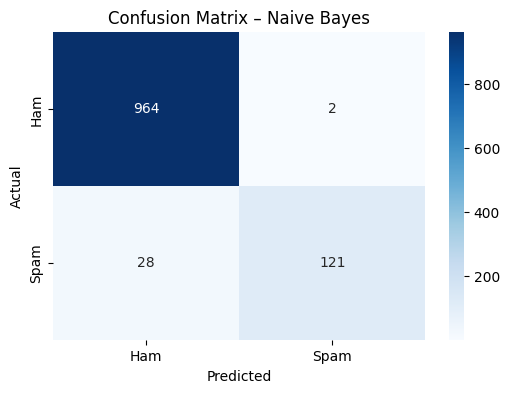

In [22]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Ham", "Spam"],
    yticklabels=["Ham", "Spam"]
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Naive Bayes")
plt.show()


In [24]:
from google.colab import drive
drive.mount('/content/drive')

results.to_csv(
    "/content/drive/MyDrive/predictions.csv",
    index=False
)


Mounted at /content/drive


In [26]:
results = pd.DataFrame({
    "Message": X_test,
    "Actual": y_test.map({0: "Ham", 1: "Spam"}),
    "Predicted": pd.Series(y_pred).map({0: "Ham", 1: "Spam"}).values
})

results.to_csv(
    "/content/drive/MyDrive/outputs/predictions.csv",
    index=False
)

results.head()


,Message,Actual,Predicted
2826,"Oh right, ok. I'll make sure that i do loads o...",Ham,Ham
3695,I am in tirupur. call you da.,Ham,Ham
3906,No that just means you have a fat head,Ham,Ham
575,"You have won ?1,000 cash or a ?2,000 prize! To...",Spam,Spam
2899,Come aftr &lt;DECIMAL&gt; ..now i m cleaning ...,Ham,Ham


In [27]:
results[results["Predicted"] == "Spam"].head()


,Message,Actual,Predicted
575,"You have won ?1,000 cash or a ?2,000 prize! To...",Spam,Spam
3057,You are now unsubscribed all services. Get ton...,Spam,Spam
2668,Wanna get laid 2nite? Want real Dogging locati...,Spam,Spam
1121,Do you want 750 anytime any network mins 150 t...,Spam,Spam
1520,"URGENT! Your Mobile No was awarded a å£2,000 B...",Spam,Spam


In [28]:
def get_ai_explanation(text):
    return (
        "This SMS contains urgency-driven keywords and patterns "
        "commonly associated with spam or phishing messages."
    )


In [29]:
sample_spam = df[df["label"] == "spam"].iloc[0]["message"]
explanation = get_ai_explanation(sample_spam)

sample_spam, explanation


("Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's",
 'This SMS contains urgency-driven keywords and patterns commonly associated with spam or phishing messages.')

In [30]:
with open("/content/drive/MyDrive/outputs/ai_explanation_log.txt", "w") as f:
    f.write(f"Message: {sample_spam}\n")
    f.write(f"Explanation: {explanation}\n")


In [31]:
def predict_sms(text):
    text_vec = vectorizer.transform([text])
    prediction = nb_model.predict(text_vec)[0]
    return "Spam" if prediction == 1 else "Ham"


In [36]:
def hybrid_predict(text):
    rule_flag = heuristic_score(text)
    ml_pred = predict_sms(text)

    if rule_flag > 0:
        return "Spam"
    return ml_pred


In [37]:
def hybrid_predict(text):
    rule_flag = heuristic_score(text)
    ml_pred = predict_sms(text)

    if rule_flag > 0:
        return "Spam"
    return ml_pred


In [1]:
# Test model

user_message = input("Enter SMS message: ")

print("\nNaive Bayes Prediction:", predict_sms(user_message))
print("Hybrid Prediction:", hybrid_predict(user_message))


NameError: name 'predict_sms' is not defined